In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import cv2
import PIL

import matplotlib.pyplot as plt
import copy
from PIL import Image

# Dataset

In [2]:
(ds_train,ds_val, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:80%]','train[80%:]', 'test'],
    shuffle_files=True,
    with_info=True,
)
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [128, 128])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

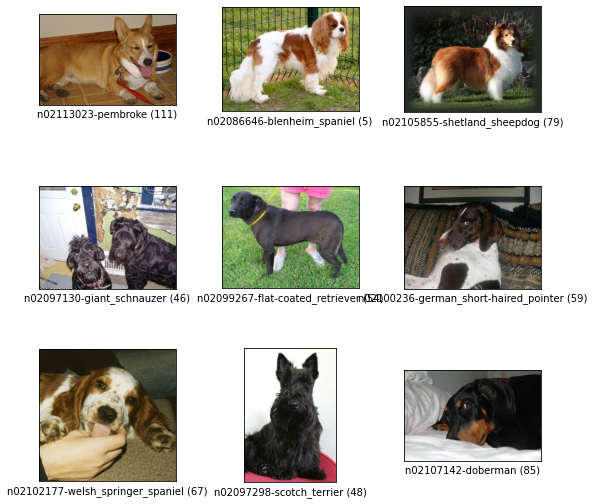

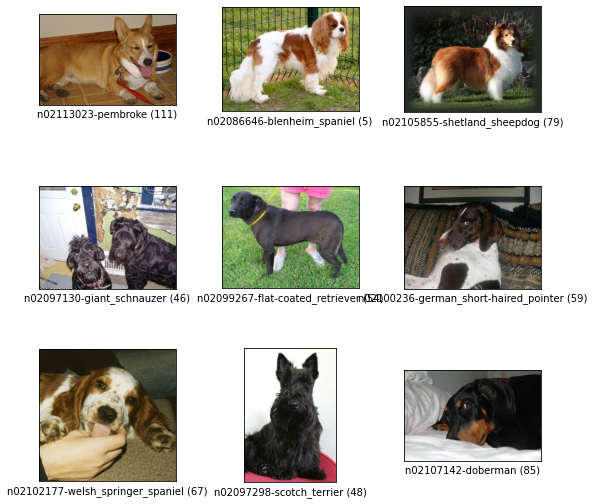

In [3]:
tfds.show_examples(ds_train, ds_info)

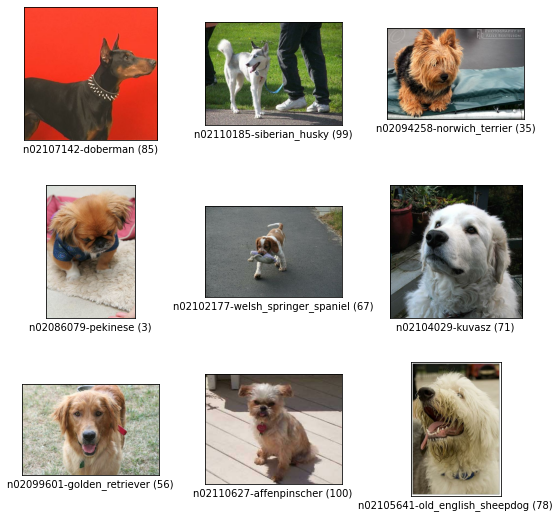

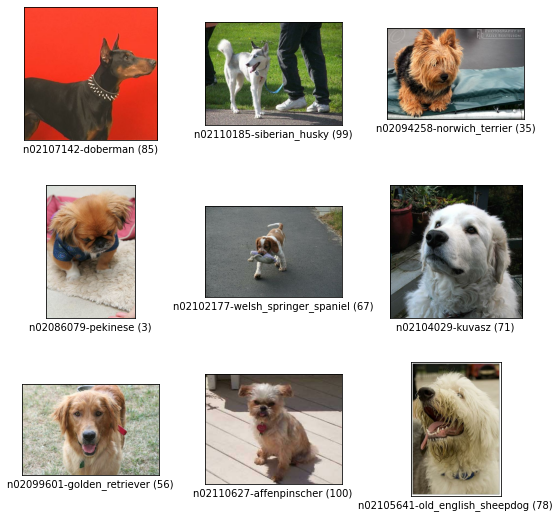

In [4]:
tfds.show_examples(ds_val, ds_info)

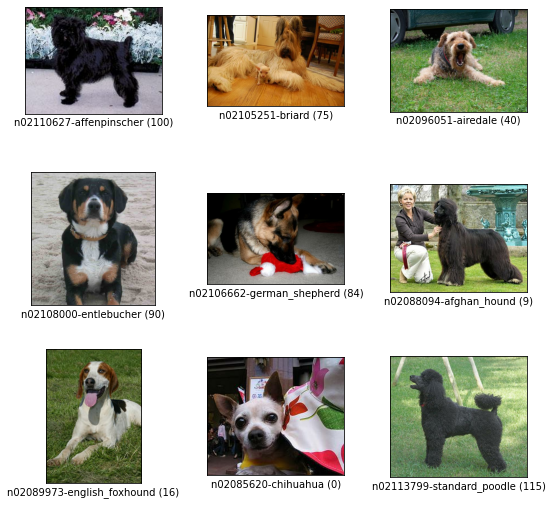

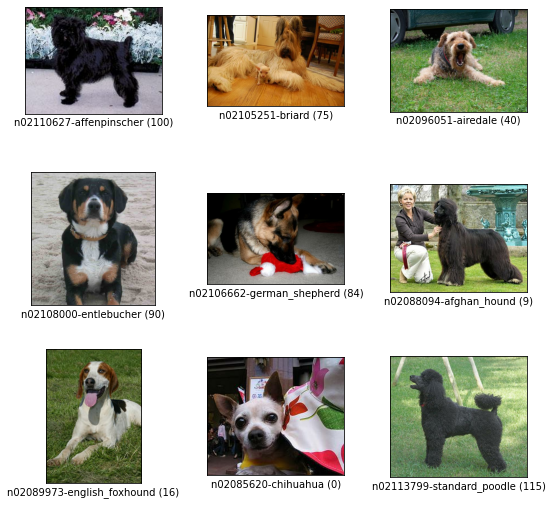

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

Preprocessing Dataset

In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_val)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 128, 128, 3)
(16,)


# Model

build

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,  
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

compile and train

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',  
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/16),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cb]
)

Epoch 1/10
600/600 [==============================] - 56s 85ms/step - loss: 3.1028 - accuracy: 0.2765 - val_loss: 5.0460 - val_accuracy: 0.0096

Epoch 00001: val_loss improved from inf to 5.04596, saving model to best_model.keras
Epoch 2/10
600/600 [==============================] - 49s 83ms/step - loss: 1.3408 - accuracy: 0.6478 - val_loss: 2.2477 - val_accuracy: 0.4200

Epoch 00002: val_loss improved from 5.04596 to 2.24775, saving model to best_model.keras
Epoch 3/10
600/600 [==============================] - 50s 83ms/step - loss: 0.4146 - accuracy: 0.9129 - val_loss: 1.9523 - val_accuracy: 0.5042

Epoch 00003: val_loss improved from 2.24775 to 1.95233, saving model to best_model.keras
Epoch 4/10
600/600 [==============================] - 50s 83ms/step - loss: 0.1215 - accuracy: 0.9858 - val_loss: 2.0488 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 1.95233
Epoch 5/10
600/600 [==============================] - 50s 83ms/step - loss: 0.0571 - accuracy: 0.9965 - va

load model

In [9]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')

# CAM & Grad-CAM Function

functions

In [85]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    item = copy.deepcopy(item)
    original_image = item['image']
    
    # 이미지 전처리
    tensor_image, class_idx = normalize_and_resize_img(item)
    
    # cam model, -3layer 필요!
    cam_model = tf.keras.models.Model([model.inputs],[model.layers[-3].output, model.output])
    
    # conv output과 prediction 얻기
    conv_outputs, preds = cam_model(tf.expand_dims(tensor_image, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 클래스 weight, weight activation은 마지막 레이어
    class_weights = model.layers[-1].get_weights()[0]
    
    # cam image 만들기
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
    
    # Score normalize-> 넘파이 -> 리사이즈해서 원래 이미지 크기 맞추기
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    
    # 원본 이미지 크기로 resize
    cam_image = cv2.resize(
        cam_image,
        (original_image.shape[1], original_image.shape[0])  # (width, height)
    )
    return cam_image

def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image
    item = copy.deepcopy(item)
    original_image = item['image']

    # 이미지 전처리
    tensor_image, class_idx = normalize_and_resize_img(item)
    
    # gradcam model, activation_layer 사용!
    grad_cam_model = tf.keras.models.Model([model.inputs],[model.get_layer(activation_layer).output, model.output])
    
    # Gradient얻기 -> tape사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_cam_model(tf.expand_dims(tensor_image, 0))
    
        loss = pred[:, class_idx] 
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient얻기

    # weights 얻기 
    weights = np.mean(grad_val, axis=(0, 1)) 
    
    # cam image 만들기
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for i, w in enumerate(weights):
        grad_cam_image += w * output[:, :, i]
    
    # ReLU 적용 및 정규화
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()

    # 원본 이미지 크기로 resize
    grad_cam_image = cv2.resize(
        grad_cam_image,
        (original_image.shape[1], original_image.shape[0])  # (width, height)
    )
    return grad_cam_image

def visualize_cam_on_image(image, cam_image, alpha = 0.5):
    # TODO: blend image
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

def get_iou(gt_bbox, pred_bbox):
    # IOU 계산: 교집합 / 합집합
    y_min_inter = max(gt_bbox[0], pred_bbox[0])  # 교집합 y_min
    x_min_inter = max(gt_bbox[1], pred_bbox[1])  # 교집합 x_min
    y_max_inter = min(gt_bbox[2], pred_bbox[2])  # 교집합 y_max
    x_max_inter = min(gt_bbox[3], pred_bbox[3])  # 교집합 x_max

     # 교집합 넓이 , GT bbox 넓이, Pred bbox 넓이, 합집합 넓이 구하기
    inter_area = max(0, y_max_inter - y_min_inter) * max(0, x_max_inter - x_min_inter)  # 교집합 넓이
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])  # ground truth 넓이
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])  # 예측 bbox 넓이
    union_area = gt_area + pred_area - inter_area  # 합집합 넓이

    iou = inter_area / union_area if union_area > 0 else 0.0  # IOU 계산
    return iou  # IOU 반환

def rect_to_minmax(rect, image):
    # 바운딩 박스 계산
    bbox = [
        rect[:,1].min()/float(image.shape[0]), 
        rect[:,0].min()/float(image.shape[1]),  
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,0].max()/float(image.shape[1]) 
    ]
    return bbox

def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("❗ No contours found. Returning dummy bbox.")
        return np.array([[0,0], [0,0], [0,0], [0,0]]) 
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


cam, gradcam 실행 후 시각화와 IOU 계산 함수

In [87]:
def show_cam_result(cam_model, item,alpha=0.5, threshold = 0.05, plot=True):
    item = copy.deepcopy(item)
    height, width =  item['image'].shape[:2]
    image = item['image'].astype(np.uint8)
    
    # Grad-CAM heatmap 생성
    cam_image = generate_cam(cam_model, item)  

    # 3채널 heatmap 생성
    cam_image_3channel = np.stack([cam_image * 255] * 3, axis=-1).astype(np.uint8)
    
    # blending 수행
    origin_image = item['image'].astype(np.uint8)
    blended_image = visualize_cam_on_image(origin_image ,cam_image_3channel , alpha=alpha)
    
    # 바운딩 박스 좌표 얻기
    rect = get_bbox(cam_image, threshold)

    # 오리지널 이미지에 빨간색 bounding box 그리기
    box_image = cv2.drawContours(item['image'], [rect], 0, (255, 0,0), 2)

    # GT bbox 정규화 → 픽셀 좌표 변환
    ymin, xmin, ymax, xmax = item['objects']['bbox'][0]
    gt_box = np.array([[
        [int(xmin * width), int(ymin * height)],
        [int(xmax * width), int(ymin * height)],
        [int(xmax * width), int(ymax * height)],
        [int(xmin * width), int(ymax * height)],
    ]], dtype=np.int32)
    
    # 이미지에 파란색으로 GT bbox그리기
    box_image = cv2.drawContours(box_image, gt_box, 0, (0, 0, 255), 2)
    
    # IOU 계산 (정규화된 박스로 변환 후 비교)
    pred_bbox = rect_to_minmax(rect, box_image)  # 예측 bbox (정규화된 [ymin, xmin, ymax, xmax])
    iou = get_iou(item['objects']['bbox'][0],pred_bbox)  # GT와 비교

    # 시각화
    if plot:
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 3, 1)
        plt.title('CAM Heatmap')
        plt.imshow(cam_image)

        plt.subplot(1, 3, 2)
        plt.title('Blended Image')
        plt.imshow(blended_image)

        plt.subplot(1, 3, 3)
        plt.title('BoundingBox')
        plt.imshow(box_image)

        plt.tight_layout()
        plt.show()

        # IOU 출력
        print(f"CAM IOU: {iou:.4f}")

    return {
        'method': 'CAM',
        'iou': float(iou),
        'pred_bbox': np.array(pred_bbox).copy(),
        'gt_bbox': np.array(item['objects']['bbox'][0]).copy(),
        'heatmap': np.array(cam_image).copy(), 
        'threshold': float(threshold)
    }

def show_gradcam_result(grad_cam_model, item, layername,alpha=0.5, threshold = 0.05,plot=True):
    item = copy.deepcopy(item)
    height, width =  item['image'].shape[:2]
    image = item['image'].astype(np.uint8)
    
    # Grad-CAM heatmap 생성
    grad_cam_image = generate_grad_cam(grad_cam_model, layername, item)  

    # 3채널 heatmap 생성
    grad_cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)
    
    # blending 수행
    origin_image = item['image'].astype(np.uint8)
    blended_image = visualize_cam_on_image(origin_image ,grad_cam_image_3channel , alpha=alpha)
    
    # 바운딩 박스 좌표 얻기
    rect = get_bbox(grad_cam_image,threshold)

    # 오리지널 이미지에 빨간색 bounding box 그리기
    box_image = cv2.drawContours(item['image'], [rect], 0, (255, 0,0), 2)

    # GT bbox 정규화 → 픽셀 좌표 변환
    ymin, xmin, ymax, xmax = item['objects']['bbox'][0]
    gt_box = np.array([[
        [int(xmin * width), int(ymin * height)],
        [int(xmax * width), int(ymin * height)],
        [int(xmax * width), int(ymax * height)],
        [int(xmin * width), int(ymax * height)],
    ]], dtype=np.int32)
    
    # 이미지에 파란색으로 GT bbox그리기
    box_image = cv2.drawContours(box_image, gt_box, 0, (0, 0, 255), 2)
    
    # IOU 계산 (정규화된 박스로 변환 후 비교)
    pred_bbox = rect_to_minmax(rect, box_image)  # 예측 bbox (정규화된 [ymin, xmin, ymax, xmax])
    iou = get_iou(item['objects']['bbox'][0],pred_bbox)  # GT와 비교

    # 시각화
    if plot:
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 3, 1)
        plt.title('Grad-CAM Heatmap')
        plt.imshow(grad_cam_image)

        plt.subplot(1, 3, 2)
        plt.title('Blended Image')
        plt.imshow(blended_image)

        plt.subplot(1, 3, 3)
        plt.title('BoundingBox')
        plt.imshow(box_image)

        plt.tight_layout()
        plt.show()

        # IOU 출력
        print(f"Layer {layername} IOU: {iou:.4f}")

    return {
        'method': 'GRAD-CAM',
        'layer': layername,
        'iou': float(iou),
        'pred_bbox': pred_bbox,
        'gt_bbox': item['objects']['bbox'][0],
        'heatmap':grad_cam_image,  
        'threshold': float(threshold)
    }

Test Functions

67


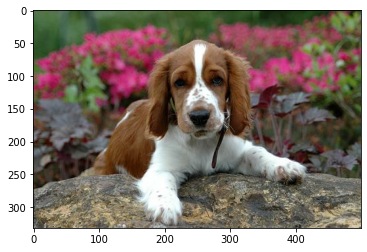

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

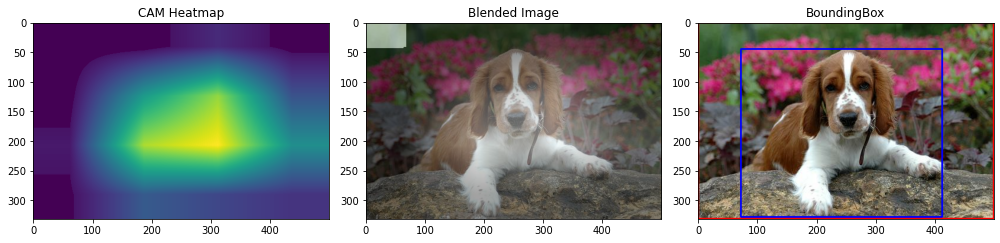

CAM IOU: 0.5826
0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: heatmap, dtype: object


In [27]:
cam_results = []

# CAM 결과 추가
cam_results.append(show_cam_result(best_model, item))
cam_df = pd.DataFrame(cam_results)
cam_df['item_label'] = int(item['label'])  
cam_df['item_filename'] = item['image/filename'].decode('utf-8')
print(cam_df['heatmap'])

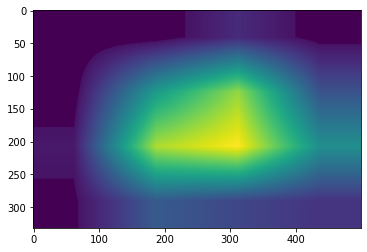

In [28]:
plt.imshow(np.array(cam_df['heatmap'].iloc[0]))
plt.show()

In [ ]:
# 레이어이름 리스트 받아서 GradCam 실행할 수 있게 함.
# 최종 return 은 plot 할 수 있도록 IOU 결과 레이어 별로 정리
gradcam_results = []
layers = [layer.name for layer in best_model.layers if layer.name.endswith('_out')]
print(f"총 {len(layers)}개 out 레이어 발견:")
print(layers)

for layer in layers:
    gradcam_results.append(show_gradcam_result(best_model, item, layer))

gradcam_df = pd.DataFrame(gradcam_results)
gradcam_df['item_label'] = int(item['label'])  
gradcam_df['item_filename'] = item['image/filename'].decode('utf-8')
gradcam_df

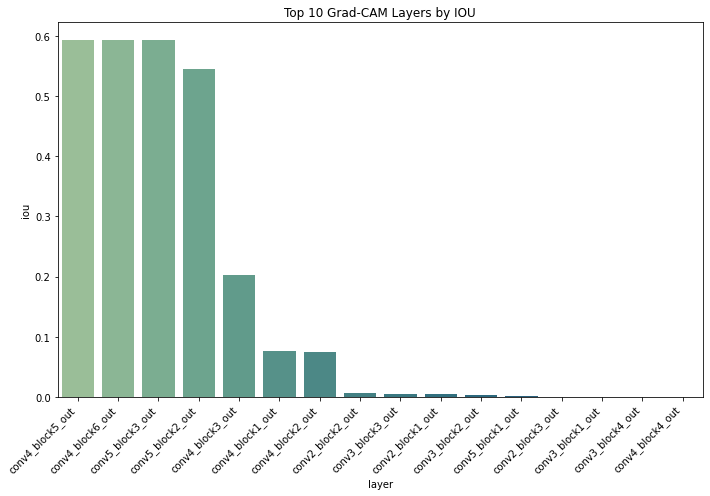

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.barplot(data=gradcam_df.sort_values(by='iou', ascending=False), x='layer', y='iou', palette='crest')
plt.title("Top 10 Grad-CAM Layers by IOU")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Experiment

- CAM, GRAD-CAM for 50 images
    - GRAD-CAM : all out layers
    - threshold 3가지
        -  (threshold 0.05)
        -  (threshold 0.075)
        -  (threshold 0.1)
- Evaluate
   - IOU Score

CAM & GRAD-CAM for 10 images

In [88]:
import tqdm
threshold_config = [0.05,0.075,0.1]
filename_to_image = {}
gradcam_rows = []
cam_rows = []

# gradcam 할 layer (전체 out layer)
layers = [layer.name for layer in best_model.layers if layer.name.endswith('_out')]
print(f"총 {len(layers)}개 out 레이어 발견:")
print(layers)

총 16개 out 레이어 발견:
['conv2_block1_out', 'conv2_block2_out', 'conv2_block3_out', 'conv3_block1_out', 'conv3_block2_out', 'conv3_block3_out', 'conv3_block4_out', 'conv4_block1_out', 'conv4_block2_out', 'conv4_block3_out', 'conv4_block4_out', 'conv4_block5_out', 'conv4_block6_out', 'conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out']


In [138]:
indexed_ds = ds_test.enumerate()
for index_tensor, item in tqdm.tqdm(indexed_ds.take(50)):
    index = int(index_tensor.numpy())
    label = int(item['label'])
    image = item['image']
    bbox = item['objects']['bbox']
    filename = item['image/filename'].numpy().decode('utf-8')

    item['image'] = item['image'].numpy()
    
    # 파일이름-이미지 딕셔너리 저장
    filename_to_image[filename] = image
    
    for th in threshold_config:
        # CAM
        cam_result =show_cam_result(best_model, item, threshold = th,plot=False )
        cam_result['item_label'] = label
        cam_result['item_filename'] = filename
        cam_result['threshold'] = th
        cam_rows.append(cam_result)

        # Grad-CAM
        for layer in layers:
            gradcam_result = show_gradcam_result(best_model, item, layer,threshold = th,plot=False)
            gradcam_result['item_label'] = label
            gradcam_result['item_filename'] = filename
            gradcam_result['threshold'] = th 
            gradcam_rows.append(gradcam_result)

cam_df = pd.DataFrame(cam_rows)
gradcam_df = pd.DataFrame(gradcam_rows)
print(cam_df.shape,gradcam_df.shape)

 12%|█▏        | 6/50 [02:40<19:35, 26.72s/it]

❗ No contours found. Returning dummy bbox.
❗ No contours found. Returning dummy bbox.
❗ No contours found. Returning dummy bbox.


 94%|█████████▍| 47/50 [21:08<01:20, 26.88s/it]

❗ No contours found. Returning dummy bbox.
❗ No contours found. Returning dummy bbox.
❗ No contours found. Returning dummy bbox.
❗ No contours found. Returning dummy bbox.
❗ No contours found. Returning dummy bbox.
❗ No contours found. Returning dummy bbox.


100%|██████████| 50/50 [22:31<00:00, 27.03s/it]

(150, 8) (2400, 9)


save results and filename to image dictionary

In [139]:
import pickle

import re
# 이미지 파일 이름 경로 일부 제거
def clean_filename(name):
    name = name.split("/")[-2]
    return name

cam_df["item_filename"] = cam_df["item_filename"].apply(clean_filename)
gradcam_df["item_filename"] = gradcam_df["item_filename"].apply(clean_filename)
filename_to_image = {
    clean_filename(k): v for k, v in filename_to_image.items()
}

In [140]:
with open("filename_to_image.pkl", "wb") as f:
    pickle.dump(filename_to_image, f)
    
cam_df.to_csv("cam_results.csv", index=False)
gradcam_df.to_csv("gradcam_results.csv", index=False)

load results

In [78]:
import pandas as pd
import pickle
    
# 파일 로드
cam_df = pd.read_csv("cam_results.csv")
gradcam_df = pd.read_csv("gradcam_results.csv")

cam_df["iou"] =cam_df["iou"].apply(lambda x: float(x))
cam_df['layer'] = "CAM"
gradcam_df["iou"] =gradcam_df["iou"].apply(lambda x: float(x))

with open("filename_to_image.pkl", "rb") as f:
    filename_to_image = pickle.load(f)

print(cam_df.shape,gradcam_df.shape)
cam_df.head(3)

(150, 9) (2400, 9)


method       iou                                      pred_bbox  \
0    CAM  0.427674  [0.         0.         0.99733333 0.998     ]   
1    CAM  0.427674  [0.         0.         0.99733333 0.998     ]   
2    CAM  0.427674  [0.         0.         0.99733333 0.998     ]   

                                         gt_bbox  \
0  [0.13066667 0.488      0.96533334 0.998     ]   
1  [0.13066667 0.488      0.96533334 0.998     ]   
2  [0.13066667 0.488      0.96533334 0.998     ]   

                                             heatmap  threshold  item_label  \
0  [[0.05864433 0.05864433 0.05864433 ... 0.17022...      0.050         108   
1  [[0.         0.         0.         ... 0.17022...      0.075         108   
2  [[0.        0.        0.        ... 0.1702202 ...      0.100         108   

    item_filename layer  
0  n02112137-chow   CAM  
1  n02112137-chow   CAM  
2  n02112137-chow   CAM

# Result

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt


# 얻은 데이터프레임으로 CAM 시각화 함수
def show_cam_visualization(row, filename_to_image):
    filename = row['item_filename']
    method = row['method']
    iou = row['iou']
    heatmap = np.array(row['heatmap'])
    pred_bbox = row['pred_bbox']
    gt_bbox = row['gt_bbox']
    th = row['threshold']

    if isinstance(heatmap, str):
        heatmap = np.array(ast.literal_eval(heatmap), dtype=np.float32)
    else:
        heatmap = np.array(heatmap, dtype=np.float32)

    pred_bbox = row['pred_bbox']
    if isinstance(pred_bbox, str):
        pred_bbox = np.array(ast.literal_eval(pred_bbox))
    
    gt_bbox = row['gt_bbox']
    if isinstance(gt_bbox, str):
        gt_bbox = np.array(ast.literal_eval(gt_bbox))

    if filename not in filename_to_image:
        print(f"원본 이미지가 존재하지 않습니다: {filename}")
        return

    original = np.asarray(filename_to_image[filename], dtype=np.uint8)
    height, width = original.shape[:2]
    print(dtype)
    heatmap_3ch = np.stack([heatmap * 255] * 3, axis=-1).astype(np.uint8)
    blended = cv2.addWeighted(original, 0.5, heatmap_3ch, 0.5, 0.0)

    box_image = original.copy()

    y1, x1, y2, x2 = pred_bbox
    pred_box = np.array([[
        [int(x1 * width), int(y1 * height)],
        [int(x2 * width), int(y1 * height)],
        [int(x2 * width), int(y2 * height)],
        [int(x1 * width), int(y2 * height)],
    ]], dtype=np.int32)
    cv2.drawContours(box_image, pred_box, 0, (255, 0, 0), 2)

    y1g, x1g, y2g, x2g = gt_bbox
    gt_box = np.array([[
        [int(x1g * width), int(y1g * height)],
        [int(x2g * width), int(y1g * height)],
        [int(x2g * width), int(y2g * height)],
        [int(x1g * width), int(y2g * height)],
    ]], dtype=np.int32)
    cv2.drawContours(box_image, gt_box, 0, (0, 0, 255), 2)

    plt.figure(figsize=(14, 5))
    plt.suptitle(f"{method} | {filename}\nIOU: {iou:.4f}\;Threshold: {th}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title(f"{method} Heatmap")
    plt.imshow(heatmap)

    plt.subplot(1, 3, 2)
    plt.title("Blended Image")
    plt.imshow(blended)

    plt.subplot(1, 3, 3)
    plt.title("Bounding Boxes\nRed: Pred, Blue: GT")
    plt.imshow(box_image)

    plt.tight_layout()
    plt.show()

# 얻은 데이터프레임으로 Grad-CAM 시각화 함수
def show_gradcam_visualization(row, filename_to_image):
    filename = row['item_filename']
    layer = row['layer']
    heatmap = row['heatmap']
    iou = row['iou']
    pred_bbox = row['pred_bbox']
    gt_bbox = row['gt_bbox']
    th = row['threshold']

    if filename not in filename_to_image:
        print(f"원본 이미지가 존재하지 않습니다: {filename}")
        return

    original = filename_to_image[filename]
    original = np.asarray(original, dtype=np.uint8)
    height, width = original.shape[:2]

    # Heatmap 3채널 변환
    heatmap_3ch = np.stack([heatmap * 255] * 3, axis=-1).astype(np.uint8)
    blended = cv2.addWeighted(original, 0.5, heatmap_3ch, 0.5, 0.0)

    # Bounding Box 이미지 복사
    box_image = original.copy()

    # 예측 bbox -> 실제 픽셀 좌표로 변환
    y1, x1, y2, x2 = pred_bbox
    pred_box = np.array([[
        [int(x1 * width), int(y1 * height)],
        [int(x2 * width), int(y1 * height)],
        [int(x2 * width), int(y2 * height)],
        [int(x1 * width), int(y2 * height)],
    ]], dtype=np.int32)
    cv2.drawContours(box_image, pred_box, 0, (255, 0, 0), 2)  # 빨강

    # GT bbox
    y1g, x1g, y2g, x2g = gt_bbox
    gt_box = np.array([[
        [int(x1g * width), int(y1g * height)],
        [int(x2g * width), int(y1g * height)],
        [int(x2g * width), int(y2g * height)],
        [int(x1g * width), int(y2g * height)],
    ]], dtype=np.int32)
    cv2.drawContours(box_image, gt_box, 0, (0, 0, 255), 2)  # 파랑

    # 시각화 출력
    plt.figure(figsize=(14, 5))
    plt.suptitle(f"{filename} | {layer}\nIOU: {iou:.4f}\;Threshold: {th}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap)

    plt.subplot(1, 3, 2)
    plt.title("Blended Image")
    plt.imshow(blended)
    
    plt.subplot(1, 3, 3)
    plt.title("Bounding Boxes\nRed: Pred, Blue: GT")
    plt.imshow(box_image)

    plt.tight_layout()
    plt.show()

# df의 method 기준으로 시각화방식 선택
def show_any_cam_visualization(row, filename_to_image):
    if row['method'] == 'CAM':
        show_cam_visualization(row, filename_to_image)
    elif row['method'] == 'GRAD-CAM':
        show_gradcam_visualization(row, filename_to_image)
    else:
        print(f"Unknown method: {row['method']}")
        
import re
# 이미지 파일 이름 경로 일부 제거
def clean_filename(name):
    name = name.split("/")[-2]
    return name


# Grad-CAM Vs CAM 

IOU Score 통계량 확인을 위한 함수

CI : T-test

In [44]:
from scipy.stats import t
import numpy as np

layers = [layer.name for layer in best_model.layers if layer.name.endswith('_out')]
order =sorted(layers, reverse=True)
order = ['CAM'] + order

def compute_ci(row):
    m = row['Mean_IOU']
    s = row['Std']
    se = s / np.sqrt(n)
    margin = t_critical * se

    return pd.Series({
        'CI_Lower': m - margin,
        'CI_Upper': m + margin
    })

def get_integrated_df(cam_df,gradcam_df,threshold = 0.05, n = 50):
    # 서브셋 추출
    cam_subset = cam_df[cam_df['threshold']==threshold].copy()
    gradcam_subset = gradcam_df[
        (gradcam_df["threshold"] ==threshold )
    ].copy()
    iou_df = pd.concat([cam_subset, gradcam_subset], ignore_index=True)

    # 통계량 계산
    layer_stats = iou_df.groupby("layer")["iou"].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False).reset_index()
    layer_stats.columns = ['Layer', 'Mean_IOU', 'Std', 'Count']

    # 신뢰수준 95% 설정
    confidence = 0.95
    df = n - 1
    t_critical = t.ppf((1 + confidence) / 2., df)  # t값

    # CI 계산 
    ci_bounds_fixed = layer_stats.apply(compute_ci, axis=1)
    layer_stats_fixed_n = pd.concat([layer_stats, ci_bounds_fixed], axis=1)

    return iou_df, layer_stats_fixed_n

각 threshold별 서브셋, CI 95% 계산

In [46]:
iou_df_1, layer_stats_fixed_n_1 = get_integrated_df(cam_df,gradcam_df,threshold = 0.05, n = 50)
iou_df_2, layer_stats_fixed_n_2 = get_integrated_df(cam_df,gradcam_df,threshold = 0.075, n = 50)
iou_df_3, layer_stats_fixed_n_3 = get_integrated_df(cam_df,gradcam_df,threshold = 0.1, n = 50)

threshold_list = [0.05, 0.075, 0.1]
integrated_stats = {
    0.05: get_integrated_df(cam_df, gradcam_df, threshold=0.05, n=50),
    0.075: get_integrated_df(cam_df, gradcam_df, threshold=0.075, n=50),
    0.1: get_integrated_df(cam_df, gradcam_df, threshold=0.1, n=50)
}

Box plot

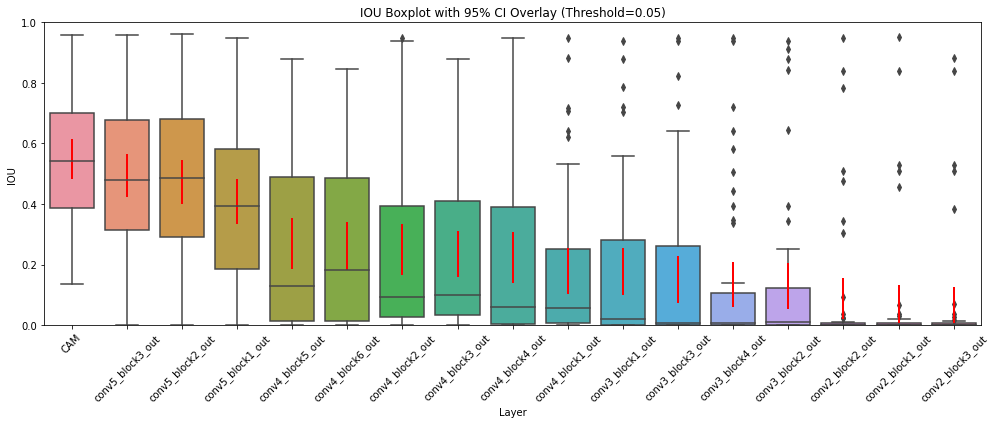

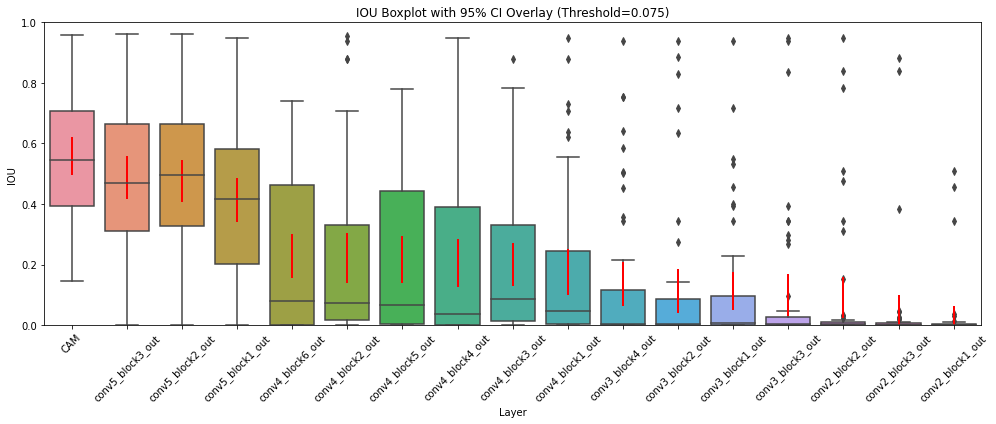

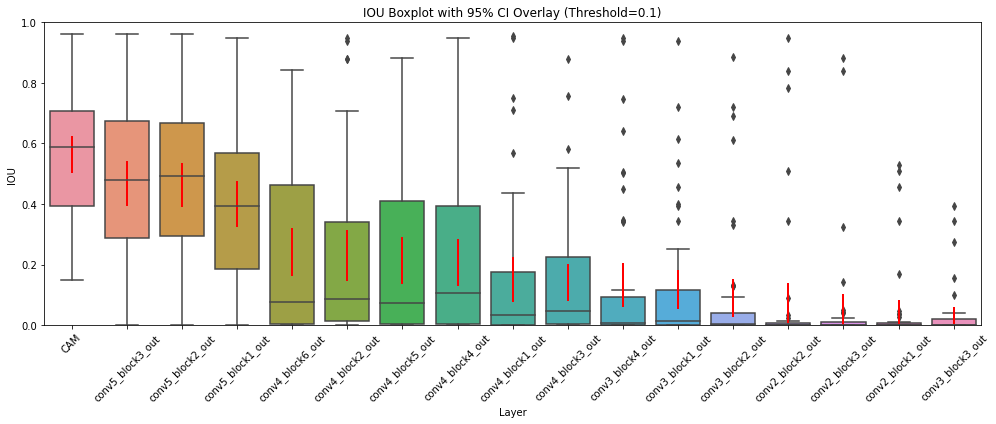

In [47]:
for th in threshold_list:
    iou_df, layer_stats_fixed_n = integrated_stats[th]

    # boxplot
    plt.figure(figsize=(14, 6))
    order = layer_stats_fixed_n.sort_values("Mean_IOU", ascending=False)['Layer']
    sns.boxplot(data=iou_df, x="layer", y="iou", order=order)

    # CI error bar
    for i, (_, row) in enumerate(layer_stats_fixed_n.iterrows()):
        plt.plot([i, i], [row['CI_Lower'], row['CI_Upper']], color='red', linewidth=2)

    plt.title(f"IOU Boxplot with 95% CI Overlay (Threshold={th})")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.xlabel("Layer")
    plt.ylabel("IOU")
    plt.tight_layout()
    plt.show()

CAM 보다 Grad CAM 에서 IOU 값이 낮게 나왔다. GradCAM 내부에서는 top위치의 conv block 에서 IOU가 높아지는 경향성을 보임
Bottom 위치의 Conv block일 수록 Mean IOU 작음.  

CAM과 Grad-Cam IOU가 높게 나온 레이어(conv5)를 비교했을 떄
모두 CAM에서 가장 높은 IOU를 보였다.
문제는 신뢰구간이 겹치고 있기 때문에 지금의 데이터로는 실제로 유의미하게 차이난다고 말할 수는 없을 것 같다. 


출력 확인

  0%|          | 0/1 [00:00<?, ?it/s]

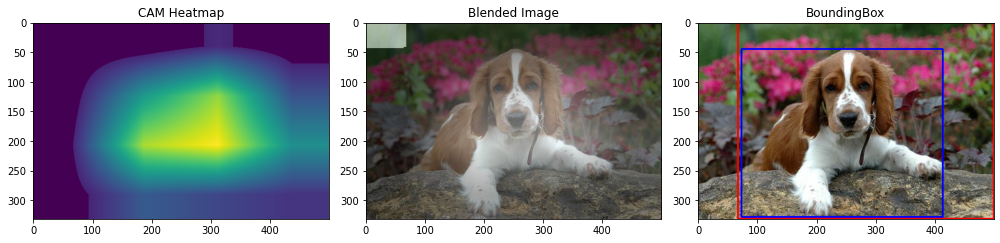

CAM IOU: 0.6729


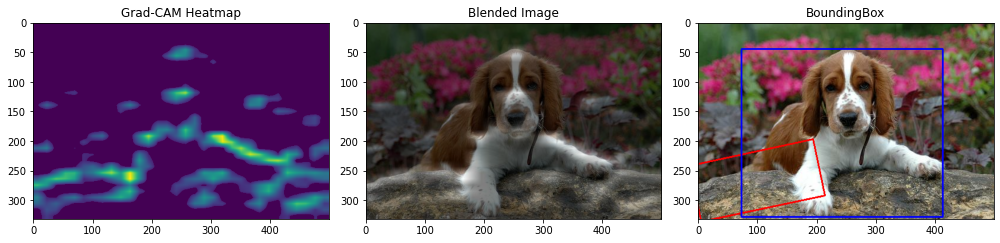

Layer conv2_block1_out IOU: 0.1686


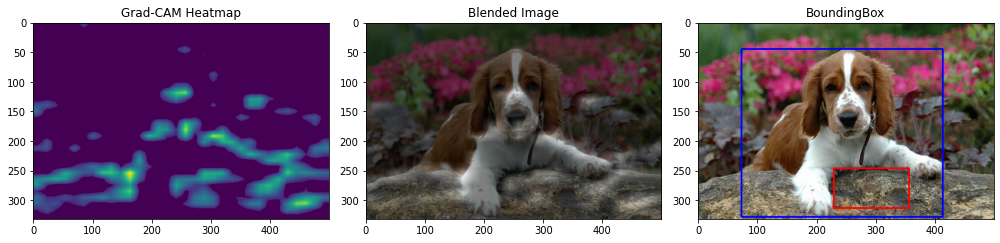

Layer conv2_block2_out IOU: 0.0884


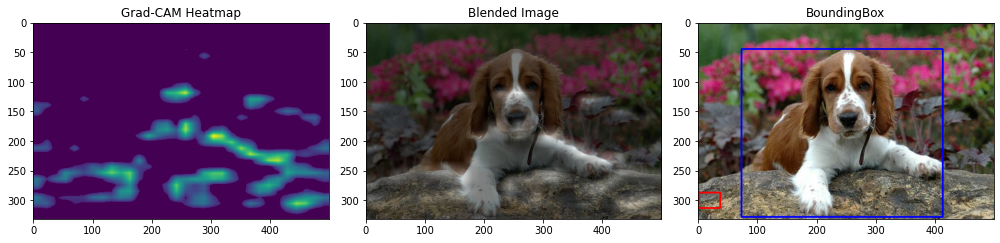

Layer conv2_block3_out IOU: 0.0000


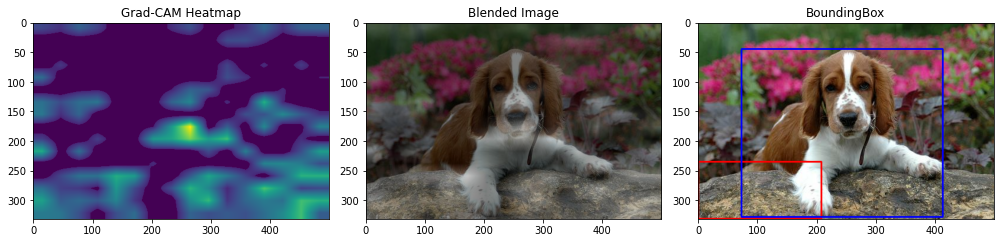

Layer conv3_block1_out IOU: 0.1211


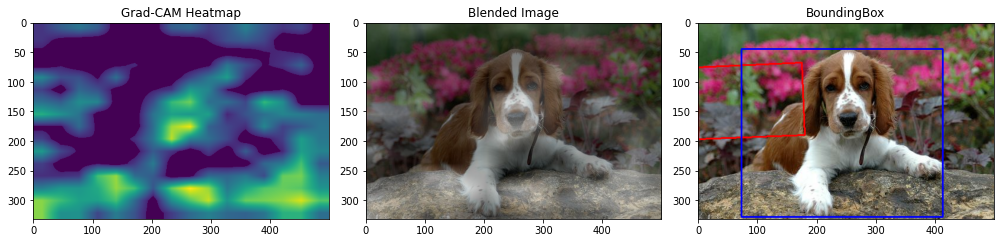

Layer conv3_block2_out IOU: 0.1302


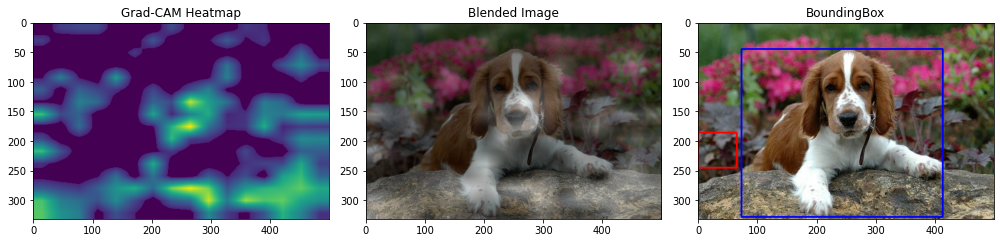

Layer conv3_block3_out IOU: 0.0000


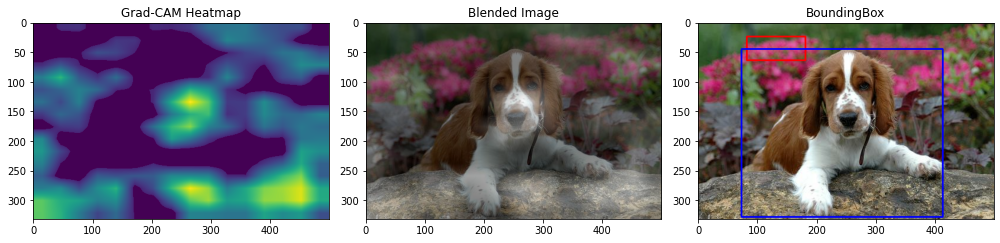

Layer conv3_block4_out IOU: 0.0191


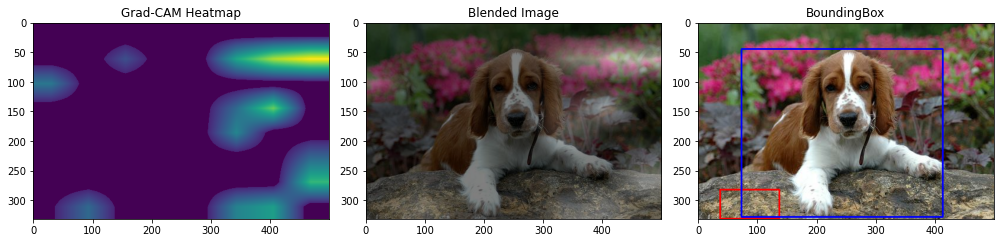

Layer conv4_block1_out IOU: 0.0300


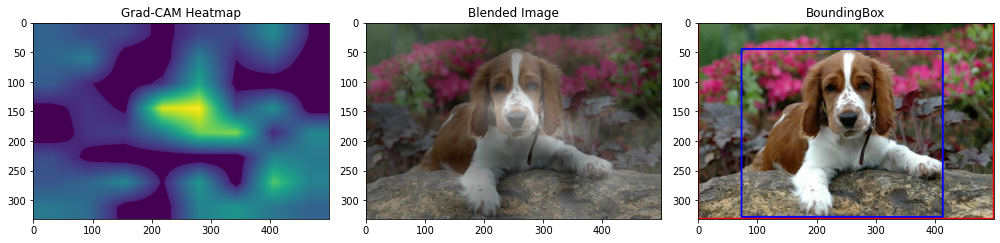

Layer conv4_block2_out IOU: 0.5826


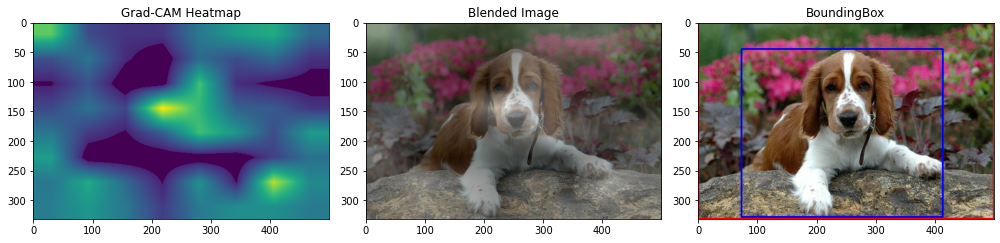

Layer conv4_block3_out IOU: 0.5826


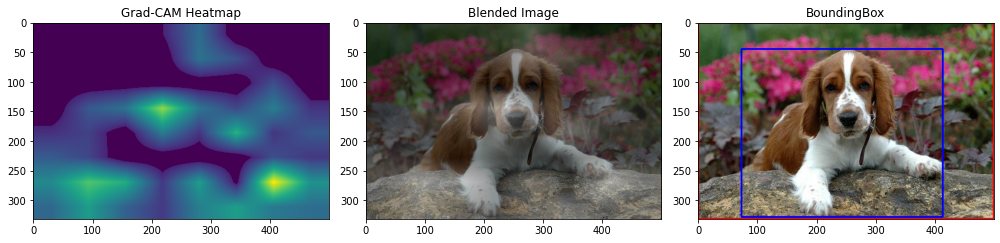

Layer conv4_block4_out IOU: 0.5826


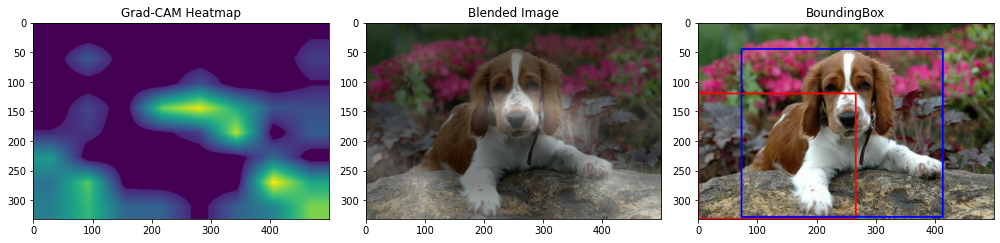

Layer conv4_block5_out IOU: 0.3578


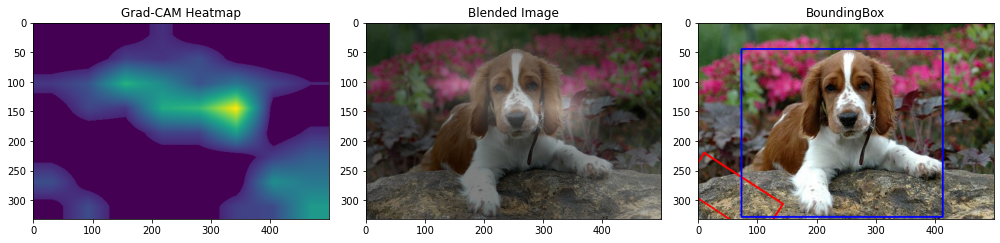

Layer conv4_block6_out IOU: 0.0666


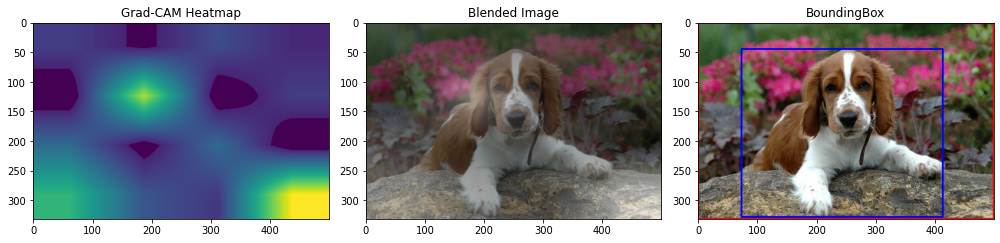

Layer conv5_block1_out IOU: 0.5826


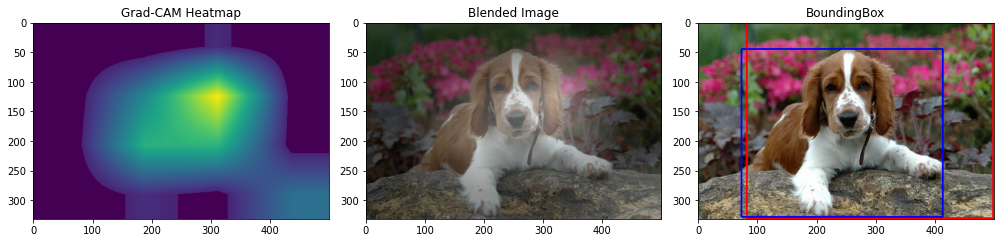

Layer conv5_block2_out IOU: 0.6699


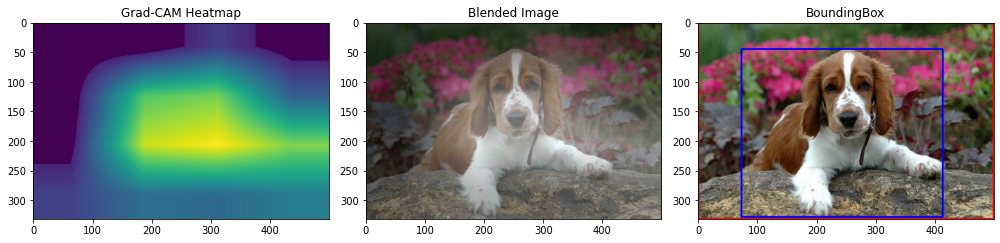

100%|██████████| 1/1 [00:17<00:00, 17.92s/it]

Layer conv5_block3_out IOU: 0.5826


In [94]:
indexed_ds = ds_test.enumerate()
threshold_config=[0.1]
for index_tensor, item in tqdm.tqdm(indexed_ds.take(1)):
    index = int(index_tensor.numpy())
    label = int(item['label'])
    image = item['image']
    bbox = item['objects']['bbox']
    filename = item['image/filename'].numpy().decode('utf-8')

    item['image'] = item['image'].numpy()
    
    # 파일이름-이미지 딕셔너리 저장
    filename_to_image[filename] = image
    
    for th in threshold_config:
        # CAM
        cam_result =show_cam_result(best_model, item, threshold = th,plot=True )
        cam_result['item_label'] = label
        cam_result['item_filename'] = filename
        cam_result['threshold'] = th
        cam_rows.append(cam_result)

        # Grad-CAM
        for layer in layers:
            gradcam_result = show_gradcam_result(best_model, item, layer,threshold = th,plot=True)
            gradcam_result['item_label'] = label
            gradcam_result['item_filename'] = filename
            gradcam_result['threshold'] = th 
            gradcam_rows.append(gradcam_result)


# 회고

전반적으로 CAM 에서 Grad CAM에서 더 좋은  localization 성능을 보였다.
다만 CAM의 경우에는 마지막레이어 부분만 사용가능하다는 점에서 XAI를 위해서는 Grad-CAM또한 유용하게 사용 가능할 것 같다.